### Instalación de pyspark y librerías

In [ ]:
!pip install pyspark
!pip install -U -q PyDriver
!apt update
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/de

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd
from operator import add

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install --quiet findspark
import findspark
findspark.init()

### Crear sesión de Pyspark

In [ ]:
spark = SparkSession.builder \
    .appName("Pandas with PySpark") \
    .getOrCreate()

In [ ]:
spark = SparkSession.builder.getOrCreate()

### Leemos las bases de datos

In [ ]:
df_deudor = spark.read.csv("h_deudor_13000.csv", header=True, inferSchema=True)

In [ ]:
df_deudor.show(10)

+------+---------+------------+-------------------+------------+-------------------+------------+-------------------+---------------------+
|CODMES|clienteID|FLAG_BANCO_A|MONTO_DEUDA_BANCO_A|FLAG_BANCO_B|MONTO_DEUDA_BANCO_B|FLAG_BANCO_C|MONTO_DEUDA_BANCO_C|MONTO_DEUDA_USD_TOTAL|
+------+---------+------------+-------------------+------------+-------------------+------------+-------------------+---------------------+
|202401| CL000001|           1|             830.04|           0|                0.0|           1|            3216.42|              4046.46|
|202401| CL000002|           0|                0.0|           0|                0.0|           0|                0.0|                  0.0|
|202401| CL000003|           1|             1348.1|           1|             6099.6|           1|            4756.13|             12203.83|
|202401| CL000004|           1|           27578.45|           1|            5271.25|           1|            1420.05|             34269.75|
|202401| CL000005|  

In [ ]:
df_deudor.columns

['CODMES',
 'clienteID',
 'FLAG_BANCO_A',
 'MONTO_DEUDA_BANCO_A',
 'FLAG_BANCO_B',
 'MONTO_DEUDA_BANCO_B',
 'FLAG_BANCO_C',
 'MONTO_DEUDA_BANCO_C',
 'MONTO_DEUDA_USD_TOTAL']

In [ ]:
df_deudor.count()

13000

In [ ]:
df_deudor.select('CODMES').distinct().orderBy('CODMES').show()

+------+
|CODMES|
+------+
|202401|
|202402|
|202403|
|202404|
|202405|
|202406|
|202407|
|202408|
|202409|
|202410|
|202411|
|202412|
|202501|
+------+



In [ ]:
df_demo = spark.read.csv("h_demografico_13000.csv", header=True, inferSchema=True)

In [ ]:
df_demo.show(10)

+------+---------+--------+-------+----+--------+
|CODMES|clienteID|segmento|NUMEDSD|SEXO|ESTCIVIL|
+------+---------+--------+-------+----+--------+
|202401| CL000001|Personas|   33.0| fem|     viu|
|202401| CL000002|Personas|   28.0| mas|     div|
|202401| CL000003| Empresa|   NULL|NULL|    NULL|
|202401| CL000004| Empresa|   NULL|NULL|    NULL|
|202401| CL000005| Empresa|   NULL|NULL|    NULL|
|202401| CL000006|Personas|   18.0| fem|     cas|
|202401| CL000007| Empresa|   NULL|NULL|    NULL|
|202401| CL000008| Empresa|   NULL|NULL|    NULL|
|202401| CL000009|Personas|   36.0| fem|     div|
|202401| CL000010|Personas|   31.0| fem|     viu|
+------+---------+--------+-------+----+--------+
only showing top 10 rows



In [ ]:
df_demo.select('CODMES').distinct().orderBy('CODMES').show()

+------+
|CODMES|
+------+
|202401|
|202402|
|202403|
|202404|
|202405|
|202406|
|202407|
|202408|
|202409|
|202410|
|202411|
|202412|
|202501|
+------+



In [ ]:
# Unir ambas tablas
df = df_deudor.join(df_demo, on=["clienteID", "CODMES"], how="left")

In [ ]:
df.show(10)

+---------+------+------------+-------------------+------------+-------------------+------------+-------------------+---------------------+--------+-------+----+--------+
|clienteID|CODMES|FLAG_BANCO_A|MONTO_DEUDA_BANCO_A|FLAG_BANCO_B|MONTO_DEUDA_BANCO_B|FLAG_BANCO_C|MONTO_DEUDA_BANCO_C|MONTO_DEUDA_USD_TOTAL|segmento|NUMEDSD|SEXO|ESTCIVIL|
+---------+------+------------+-------------------+------------+-------------------+------------+-------------------+---------------------+--------+-------+----+--------+
| CL000001|202401|           1|             830.04|           0|                0.0|           1|            3216.42|              4046.46|Personas|   33.0| fem|     viu|
| CL000002|202401|           0|                0.0|           0|                0.0|           0|                0.0|                  0.0|Personas|   28.0| mas|     div|
| CL000003|202401|           1|             1348.1|           1|             6099.6|           1|            4756.13|             12203.83| Empre

In [ ]:
df.columns

['clienteID',
 'CODMES',
 'FLAG_BANCO_A',
 'MONTO_DEUDA_BANCO_A',
 'FLAG_BANCO_B',
 'MONTO_DEUDA_BANCO_B',
 'FLAG_BANCO_C',
 'MONTO_DEUDA_BANCO_C',
 'MONTO_DEUDA_USD_TOTAL',
 'segmento',
 'NUMEDSD',
 'SEXO',
 'ESTCIVIL']

### Descriptivo de tablas

In [ ]:
# Variables numéricas
numericas = [
    'MONTO_DEUDA_BANCO_A', 'MONTO_DEUDA_BANCO_B',
    'MONTO_DEUDA_BANCO_C', 'MONTO_DEUDA_USD_TOTAL', 'NUMEDSD'
]

# Estadísticos descriptivos para variables numéricas
df.select(numericas).describe().show()

+-------+-------------------+-------------------+-------------------+---------------------+------------------+
|summary|MONTO_DEUDA_BANCO_A|MONTO_DEUDA_BANCO_B|MONTO_DEUDA_BANCO_C|MONTO_DEUDA_USD_TOTAL|           NUMEDSD|
+-------+-------------------+-------------------+-------------------+---------------------+------------------+
|  count|              13000|              13000|              13000|                13000|              6539|
|   mean|  4779.593784615396|  4811.542536153838|   4716.03707076922|    14307.17339153843|  39.4572564612326|
| stddev|  8340.210171673363|  8492.471687740524|  8421.050714726338|   14516.466135075083|12.914280792637475|
|    min|                0.0|                0.0|                0.0|                  0.0|              18.0|
|    max|           49903.42|           49841.43|           49879.28|             49999.28|              60.0|
+-------+-------------------+-------------------+-------------------+---------------------+------------------+



In [ ]:
df.groupBy('sexo').count().show()

+----+-----+
|sexo|count|
+----+-----+
|NULL| 6461|
| fem| 3393|
| mas| 3146|
+----+-----+



In [ ]:
df.groupBy('NUMEDSD').count().orderBy('NUMEDSD').show(50)

+-------+-----+
|NUMEDSD|count|
+-------+-----+
|   NULL| 6461|
|   18.0|  182|
|   19.0|  169|
|   20.0|  195|
|   21.0|  156|
|   22.0|  104|
|   23.0|  143|
|   24.0|  208|
|   25.0|  117|
|   26.0|  130|
|   27.0|  117|
|   28.0|  156|
|   29.0|  130|
|   30.0|  156|
|   31.0|  208|
|   32.0|  143|
|   33.0|  117|
|   34.0|  143|
|   35.0|  195|
|   36.0|  104|
|   37.0|  143|
|   38.0|  130|
|   39.0|   91|
|   40.0|  143|
|   41.0|  156|
|   42.0|  143|
|   43.0|  130|
|   44.0|  143|
|   45.0|  130|
|   46.0|  130|
|   47.0|  130|
|   48.0|  104|
|   49.0|  104|
|   50.0|   65|
|   51.0|  221|
|   52.0|  195|
|   53.0|  208|
|   54.0|  221|
|   55.0|  195|
|   56.0|  208|
|   57.0|  221|
|   58.0|  182|
|   59.0|  156|
|   60.0|  117|
+-------+-----+



In [ ]:
df.groupBy('flag_banco_a').count().show()

+------------+-----+
|flag_banco_a|count|
+------------+-----+
|           1| 8931|
|           0| 4069|
+------------+-----+



In [ ]:
df.groupBy('segmento').count().show()

+--------+-----+
|segmento|count|
+--------+-----+
|Personas| 6539|
| Empresa| 6461|
+--------+-----+



<ipython-input-74-8d2f26d06c18>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=flag_pd, x='Banco', y='Total', palette='pastel', legend= True)


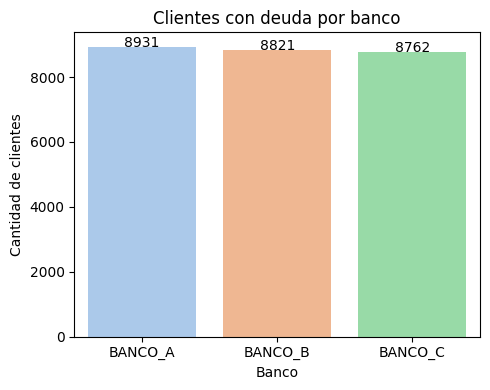

In [ ]:
# Sumar los valores de los flags (suponiendo que 1 = tiene deuda)
flag_sums = df.select([
    sum("FLAG_BANCO_A").alias("BANCO_A"),
    sum("FLAG_BANCO_B").alias("BANCO_B"),
    sum("FLAG_BANCO_C").alias("BANCO_C")
])

# Convertir a pandas para graficar
flag_pd = flag_sums.toPandas().T.reset_index()
flag_pd.columns = ['Banco', 'Total']

# Graficar
plt.figure(figsize=(5, 4))
sns.barplot(data=flag_pd, x='Banco', y='Total', palette='pastel')
for index, row in flag_pd.iterrows():
    plt.text(index, row['Total'] + 10, int(row['Total']), ha='center')
plt.title("Clientes con deuda por banco")
plt.ylabel("Cantidad de clientes")
plt.xlabel("Banco")
plt.tight_layout()
plt.show()

### Otros

In [ ]:
import pandas as pd

# Ejemplo de DataFrame de pandas
pdf = pd.DataFrame({
    "nombre": ["Ana", "Luis", "Juan"],
    "edad": [23, 30, 25]
})

# Convertir pandas a pyspark
df_spark = spark.createDataFrame(pdf)

# Mostrarlo
df_spark.show()

+------+----+
|nombre|edad|
+------+----+
|   Ana|  23|
|  Luis|  30|
|  Juan|  25|
+------+----+

